In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
%matplotlib inline

In [52]:
def radar_factory(num_vars, frame='circle'):

    # calculate evenly-spaced axis angles
    theta = 2*np.pi * np.linspace(0, 1-1./num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180/np.pi, labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


In [53]:
def unit_poly_verts(theta):

    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [211]:
def example_data():

    data = {
        'column names':
            ['Preserving Night Sky In Specific Bands', 'Visible Light Pollution'.ljust(90), 'Illuminating the Street'.ljust(90), 'Traffic Light - Street Light Color Separation'.ljust(175), 'Color Rendering Index'.ljust(90), 'Cost Benefit - Initial, Power, Maintenance/Lifetime'.rjust(135), 'Glare'.rjust(15), 'Light Trespass'.rjust(38),
             'Bio - fill in the blank'.rjust(55)],
        '':
            [[1, 2, 2, 2, 2, 2, 2, 2, 2]
             ]}
    return data


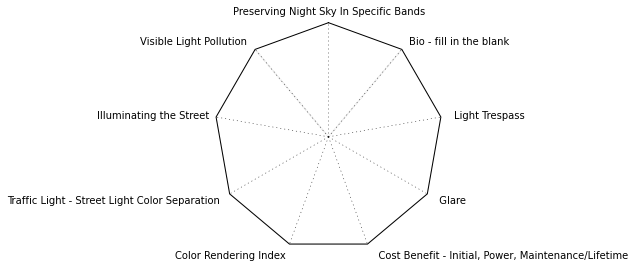

In [214]:

if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop('column names')

    fig = plt.figure(figsize=(9, 9))
#    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['w', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for n, title in enumerate(data.keys()):
        ax = fig.add_subplot(2, 2, n+1, projection='radar')
        plt.rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(data[title], colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
#    plt.subplot(2, 2, 1)
#    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#    legend = plt.legend(labels, loc=(0.9, .95), labelspacing=0.1)
#    plt.setp(legend.get_texts(), fontsize='small')

#    plt.figtext(.3, 0.965, 'Factors for Modern Streetlights',
#                ha='center', color='black', weight='bold', size='large')
    plt.show()